In [1]:
import os
import pathlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gemmi

In [2]:
import pickle

In [3]:
import seaborn as sns

In [4]:
## Example "FORMUL   2  HOH   *360()" in 1a3h_final.pdb
## Example "HETATM 2396  O   HOH A 304      58.368  33.672  27.284  1.00  7.57           O" in the coordination section in 1a3h_final.pdb.
## Use information in atomic region to count waters. Use PDBParser of biopython package.

In [5]:
# Training set.
train_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/train_split.txt", header=None)
train_list = train_list[0].tolist()
# Test set.
test_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/test_split.txt", header=None)
test_list = test_list[0].tolist()

In [6]:
len(train_list), len(test_list)

(4507, 1293)

In [7]:
## Loop through all pdb files.
pdb_path = pathlib.Path('/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data')
pdbs = list(pdb_path.glob('*_final.pdb')) # Pay attention to the pattern of names. A general "*.pdb" would result in duplicate files when looping.
# Train.
pdb_train = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in train_list:
        pdb_train.append(a)
# Test.
pdb_test = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in test_list:
        pdb_test.append(a)

In [59]:
# Store the water count dictionaries.
with open("train_WAT_dict.pkl", "wb") as f:
    pickle.dump(wc_train_dict, f)
with open("test_WAT_dict.pkl", "wb") as f:
    pickle.dump(wc_test_dict, f)

In [10]:
AA=['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 
    'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

In [12]:
# Create a dictionary of chains and the list of mols of interest for BOTH training and test sets.
data1, data2 = pdb_train, pdb_test
filter = ['HOH', 'WAT', 'H2O'] # List of crystallographic ligands.

keys=['name', 'resolution', 'water', 'AA']
chain_keys=['seq_id', 'res', 'b_fac', 'occ']
AA_wat_train_dict, AA_wat_test_dict = {k: [] for k in keys}, {k: [] for k in keys}
for all_dict, data in zip([AA_wat_train_dict, AA_wat_test_dict], [data1, data2]):
    for a in data: # Loop over all PDB structures.
        name = a.stem.split('_')[0]
        structure = gemmi.read_structure(str(a))
        # Check model.
        i = 0
        model = structure[i]  # consider the first model (skip if empty)
        while len(model) == 0:  # sometimes the first model is empty
            i += 1
            try:
                model = structure[i]
            except Exception:
                raise ValueError("Can't read valid model from the input PDB file!")
        # Chain dictionary of water molecules.
        chain_dict={}
        for chain in model:
            ind_chain={k: [] for k in chain_keys} # seq_id, res, b_fac
            res_list=[]
            id_list=[]
            b_fac=[]
            occ_list=[]
            for res in chain:
                if res.name in filter: # Check if it is not in any of the filter lists.
                    res_list.append(res.name)
                    id_list.append(str(res.seqid))
                    b_fac.append(res[0].b_iso) # Only one atom in water residue: O atom.
                    occ_list.append(res[0].occ)
            ind_chain['seq_id']=id_list
            ind_chain['res']=res_list
            ind_chain['b_fac']=b_fac
            ind_chain['occ']=occ_list
            # For each chain.
            chain_dict[chain.name] = ind_chain
        # Chain dictionary of amino acids.
        AA_dict={}
        for chain in model:
            ind_chain={k: [] for k in chain_keys} # seq_id, res, b_fac
            res_list=[]
            id_list=[]
            b_fac=[]
            occ_list=[]
            for res in chain:
                if res.name in AA: # Check if it is not in any of the amino acid.
                    res_list.append(res.name)
                    id_list.append(str(res.seqid))
                    b_fac.append([float(atom.b_iso) for atom in res]) # Many atoms in each residue. Store as list
                    occ_list.append([float(atom.occ) for atom in res])
            ind_chain['seq_id']=id_list
            ind_chain['res']=res_list
            ind_chain['b_fac']=b_fac
            ind_chain['occ']=occ_list
            # For each chain.
            AA_dict[chain.name] = ind_chain
        # Summarize as {chain: list of mols of interest}.
        all_dict['name'].append(name)
        all_dict['resolution'].append(float(structure.resolution))
        all_dict['water'].append(chain_dict)
        all_dict['AA'].append(AA_dict)


In [13]:
df_AA_water_resolution_train = pd.DataFrame(AA_wat_train_dict)
df_AA_water_resolution_test = pd.DataFrame(AA_wat_test_dict)

In [29]:
df_AA_water_resolution_train.to_pickle('AA_wat_train_dict.pkl')
df_AA_water_resolution_test.to_pickle('AA_wat_test_dict.pkl')

In [28]:
df_AA_water_resolution_test

,name,resolution,water,AA,wat_over_AA
0,6zw2,1.75,"{'A': {'seq_id': ['501', '502', '503', '504', ...","{'A': {'seq_id': ['20', '21', '22', '23', '24'...",1.030992
1,4hr3,1.80,"{'A': {'seq_id': ['601', '602', '603', '604', ...","{'A': {'seq_id': ['3', '4', '5', '6', '7', '8'...",1.314496
2,6yp2,1.80,"{'A': {'seq_id': ['401', '402', '403', '404', ...","{'A': {'seq_id': ['-4', '-3', '-2', '-1', '0',...",1.304527
3,5pbi,1.78,"{'A': {'seq_id': ['2102', '2103', '2105', '210...","{'A': {'seq_id': ['1856', '1857', '1858', '185...",1.269565
4,7f5c,1.65,"{'A': {'seq_id': ['301', '304', '305', '307', ...","{'A': {'seq_id': ['66', '67', '68', '69', '70'...",1.111111
...,...,...,...,...,...
1288,3vha,1.39,"{'A': {'seq_id': ['2', '3', '4', '5', '6', '7'...","{'A': {'seq_id': ['11', '12', '13', '14', '15'...",1.306977
1289,4xua,1.75,"{'A': {'seq_id': ['2101', '2103', '2104', '210...","{'A': {'seq_id': ['1856', '1857', '1858', '185...",1.491379
1290,7o5s,1.80,"{'A': {'seq_id': ['401', '403', '404', '405', ...","{'A': {'seq_id': ['-2', '-1', '0', '1', '2', '...",1.244635
1291,6agy,1.80,"{'A': {'seq_id': ['201', '202', '203', '204', ...","{'A': {'seq_id': ['2', '3', '4', '5', '6', '7'...",1.187919


In [42]:
print(min(df_AA_water_resolution_train.resolution.values), max(df_AA_water_resolution_train.resolution.values))
print(min(df_AA_water_resolution_test.resolution.values), max(df_AA_water_resolution_test.resolution.values))

0.64 2.2
0.99 2.4


In [22]:
water_dict = df_AA_water_resolution_test.iloc[0].water
water_dict

{'A': {'seq_id': ['501',
   '502',
   '503',
   '504',
   '505',
   '506',
   '507',
   '508',
   '509',
   '510',
   '511',
   '512',
   '513',
   '514',
   '515',
   '516',
   '517',
   '519',
   '521',
   '522',
   '523',
   '524',
   '525',
   '526',
   '527',
   '528',
   '529',
   '531',
   '532',
   '533',
   '534',
   '536',
   '537',
   '538',
   '539',
   '540',
   '541',
   '542',
   '543',
   '545',
   '546',
   '547',
   '548',
   '549',
   '550',
   '551',
   '552',
   '553',
   '554',
   '555',
   '556',
   '557',
   '558',
   '559',
   '560',
   '561',
   '562',
   '563',
   '564',
   '565',
   '566',
   '567',
   '568',
   '569',
   '570',
   '571',
   '572',
   '573',
   '574',
   '575',
   '576',
   '577',
   '578',
   '579',
   '580',
   '582',
   '584',
   '585',
   '586',
   '587',
   '588',
   '589',
   '590',
   '591',
   '592',
   '593',
   '594',
   '595',
   '596',
   '597',
   '598',
   '599',
   '600',
   '601',
   '602',
   '603',
   '604',
   '605',
   '6

In [25]:
wat_count=[]
for chain, wat_dict in water_dict.items():
    print(chain)
    print(len(wat_dict['seq_id']))
    wat_count.extend(wat_dict['seq_id'])
wat_count=len(wat_count)
print('Water count for protein: ', wat_count)

A
282
B
217
Water count for protein:  499


In [26]:
def calc_wat_over_AA(water_dict, AA_dict):
    """Divide the count of water molecule by the count of residue for each protein. Return a single value."""
    wat_count=[]
    for chain, wat_dict in water_dict.items():
        wat_count.extend(wat_dict['seq_id'])
    wat_count=len(wat_count)

    AA_count=[]
    for chain, AA_dict in AA_dict.items():
        AA_count.extend(AA_dict['seq_id'])
    AA_count=len(AA_count)
    return wat_count/AA_count

In [27]:
# Divide the count of water molecule by the count of residue for each protein.
for df in [df_AA_water_resolution_train, df_AA_water_resolution_test]:
    df['wat_over_AA'] = [calc_wat_over_AA(water_dict, AA_dict) for water_dict, AA_dict in zip(df.water, df.AA)]


Text(0.5, 1.0, 'Resolution distribution of training set')

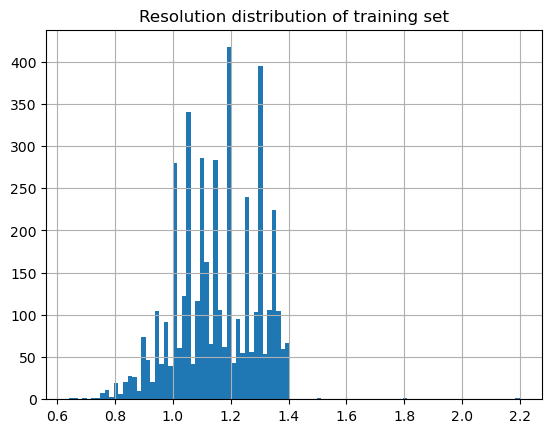

In [37]:
# Take a look at the distribution of resolution.
df_AA_water_resolution_train['resolution'].hist(bins=100)
plt.title('Resolution distribution of training set')

Text(0.5, 1.0, 'Resolution distribution of test set')

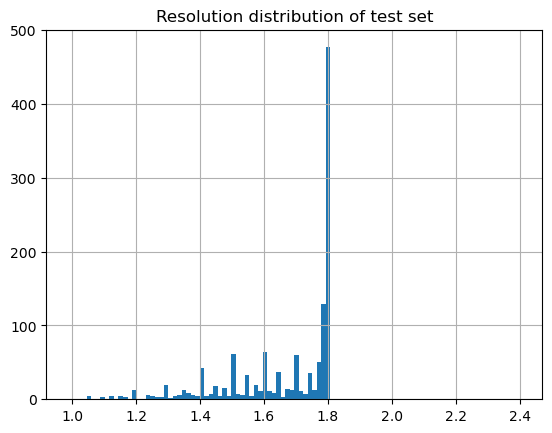

In [33]:
# Take a look at the distribution of resolution.
df_AA_water_resolution_test['resolution'].hist(bins=100)
plt.title('Resolution distribution of test set')

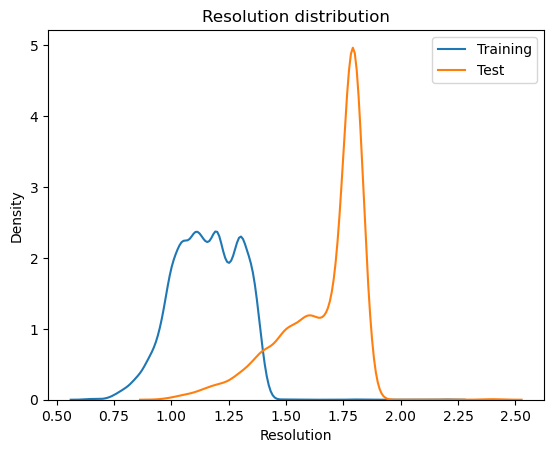

In [38]:
x_label = 'Resolution'
data = list(df_AA_water_resolution_train['resolution'].values)
data2 = list(df_AA_water_resolution_test['resolution'].values)
df = pd.DataFrame(data, columns=[x_label])
df2 = pd.DataFrame(data2, columns=[x_label])
sns.kdeplot(df, x=x_label, label='Training')
sns.kdeplot(df2, x=x_label, label='Test')
plt.xlabel(x_label)
plt.legend()
# plt.ylabel("Number of proteins")
plt.title("Resolution distribution")
plt.savefig("figures/2_b_Resolution_PDF.png", dpi=200)
plt.show()

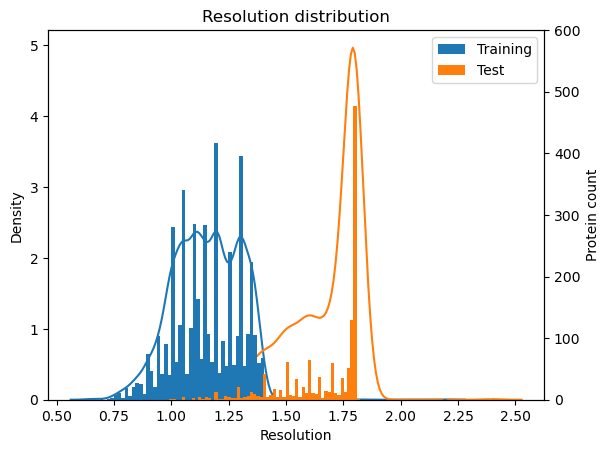

In [39]:
fig, ax = plt.subplots()
x_label = 'Resolution'
data = list(df_AA_water_resolution_train['resolution'].values)
data2 = list(df_AA_water_resolution_test['resolution'].values)
df = pd.DataFrame(data, columns=[x_label])
df2 = pd.DataFrame(data2, columns=[x_label])
sns.kdeplot(df, x=x_label, label='Training')
sns.kdeplot(df2, x=x_label, label='Test')

# overlay with histogram.
ax2 = ax.twinx()
ax2.hist(data, label='Training', bins=100)
ax2.hist(data2, label='Test', bins=100)
ax2.set_ylabel('Protein count')
ax2.set_ylim(0, 600)

plt.xlabel(x_label)
plt.legend()
# plt.ylabel("Number of proteins")
plt.title("Resolution distribution")
plt.savefig("figures/2_b_Resolution_Overlay.png", dpi=200)
plt.show()

In [49]:
train_resolutions = np.arange(min(df_AA_water_resolution_train.resolution), max(df_AA_water_resolution_train.resolution) + 0.2, 0.2)
test_resolutions = np.arange(min(df_AA_water_resolution_test.resolution), max(df_AA_water_resolution_test.resolution) + 0.2, 0.2)

In [50]:
train_resolutions, test_resolutions # [0.64 2.2]  [0.99 2.4].

(array([0.64, 0.84, 1.04, 1.24, 1.44, 1.64, 1.84, 2.04, 2.24]),
 array([0.99, 1.19, 1.39, 1.59, 1.79, 1.99, 2.19, 2.39, 2.59]))

In [59]:
df[df['resolution'] < 0.8].wat_over_AA

195     1.911894
460     1.482966
578     1.764706
649     1.657143
761     1.675000
795     1.142857
881     1.365385
1204    1.719745
1739    1.596491
2196    1.520710
2328    1.780952
2735    1.914634
2780    1.700000
2810    1.308271
3089    1.333333
3272    1.730942
3402    1.433628
3618    1.196203
3702    1.538117
3789    1.816456
3827    1.768382
3895    1.150000
3988    1.516556
3992    1.389423
4032    1.201550
4058    1.531532
4173    1.541985
4450    1.258575
Name: wat_over_AA, dtype: float64

In [68]:
df=df_AA_water_resolution_train
df[df['resolution'] > 1.4]

,name,resolution,water,AA,wat_over_AA
249,5mhx,1.5,"{'A': {'seq_id': ['707', '710', '711', '712', ...","{'A': {'seq_id': ['1', '2', '3', '4', '5', '6'...",1.438878
1665,1eaq,2.2,"{'A': {'seq_id': ['2001', '2002', '2003', '200...","{'A': {'seq_id': ['50', '52', '53', '54', '55'...",1.296296
1910,3zqw,1.8,"{'A': {'seq_id': ['2001', '2011', '2012', '201...","{'A': {'seq_id': ['1', '2', '3', '4', '5', '6'...",1.176471


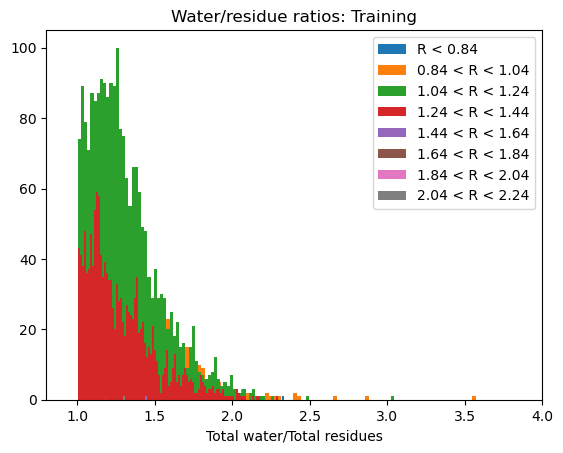

In [62]:
# Training set. water/residues for each PDB (summing).
# Loop through each resolution class.
fig, ax = plt.subplots()
for i,resolution in enumerate(train_resolutions[:-1]):
    df=df_AA_water_resolution_train
    if i == 0:
        df = df[df['resolution'] < train_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        ax.hist(data, bins=100, label=f'R < {round(train_resolutions[i+1], 2)}')
    else:
        df = df[df['resolution'] >= resolution]
        df = df[df['resolution'] < train_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        ax.hist(data, bins=100, label=f'{round(resolution, 2)} < R < {round(train_resolutions[i+1], 2)}')
ax.set_xlabel("Total water/Total residues")
ax.set_xlim(0.8, 4)
# plt.ylabel("Number of proteins")
ax.set_title("Water/residue ratios: Training")
plt.legend()
plt.savefig("figures/2_b_Resolution_train_Sum_wat_over_res_dist.png", dpi=200)
# plt.show()

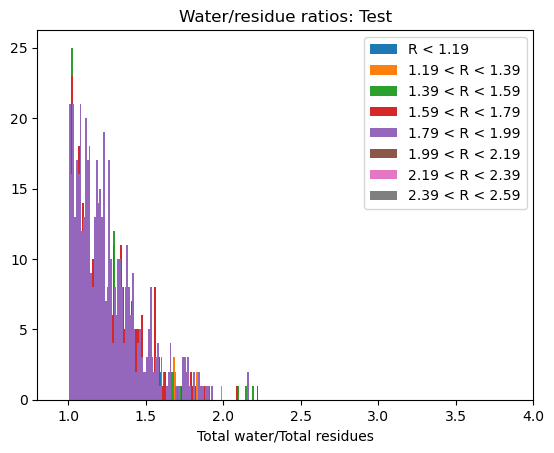

In [63]:
# Test set. water/residues for each PDB (summing).
# Loop through each resolution class.
fig, ax = plt.subplots()
for i,resolution in enumerate(test_resolutions[:-1]):
    df=df_AA_water_resolution_test
    if i == 0:
        df = df[df['resolution'] < test_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        ax.hist(data, bins=100, label=f'R < {round(test_resolutions[i+1], 2)}')
    else:
        df = df[df['resolution'] >= resolution]
        df = df[df['resolution'] < test_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        ax.hist(data, bins=100, label=f'{round(resolution, 2)} < R < {round(test_resolutions[i+1], 2)}')
ax.set_xlabel("Total water/Total residues")
ax.set_xlim(0.8, 4)
# plt.ylabel("Number of proteins")
ax.set_title("Water/residue ratios: Test")
plt.legend()
plt.savefig("figures/2_b_Resolution_test_Sum_wat_over_res_dist.png", dpi=200)
# plt.show()

/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/2029789368.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(train_resolutions[i+1], 2)}')
/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/2029789368.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(train_resolutions[i+1], 2)}')
/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/2029789368.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(train_resolutions[i+1], 2)}')
/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/2029789368.py:17:

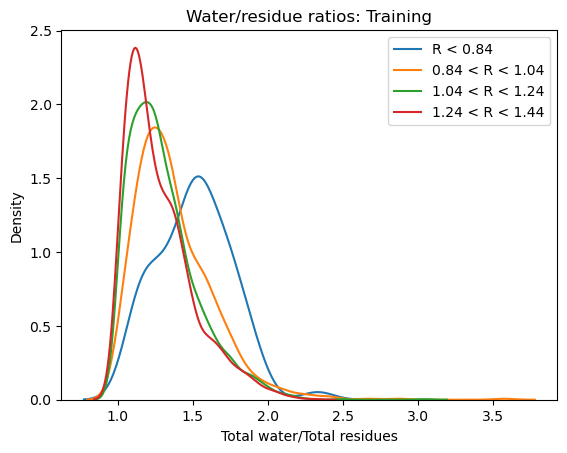

In [66]:
# Training set. water/residues for each PDB (summing).
# Loop through each resolution class.
fig, ax = plt.subplots()
x_label='Total water/Total residues'
for i,resolution in enumerate(train_resolutions[:-1]):
    df=df_AA_water_resolution_train
    if i == 0:
        df = df[df['resolution'] < train_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        df_PDF = pd.DataFrame(data, columns=[x_label])
        sns.kdeplot(df_PDF, x=x_label, label=f'R < {round(train_resolutions[i+1], 2)}')
    else:
        df = df[df['resolution'] >= resolution]
        df = df[df['resolution'] < train_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        df_PDF = pd.DataFrame(data, columns=[x_label])
        sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(train_resolutions[i+1], 2)}')
ax.set_xlabel("Total water/Total residues")
# ax.set_xlim(0.8, 4)
# plt.ylabel("Number of proteins")
ax.set_title("Water/residue ratios: Training")
plt.legend()
plt.savefig("figures/2_b_Resolution_train_Sum_wat_over_res_PDF.png", dpi=200)
# plt.show()

/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/1514379883.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(test_resolutions[i+1], 2)}')
/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/1514379883.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(test_resolutions[i+1], 2)}')
/var/folders/h1/t20btdvj4tz_k2rb3j8bm4dw0000gn/T/ipykernel_50732/1514379883.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(test_resolutions[i+1], 2)}')


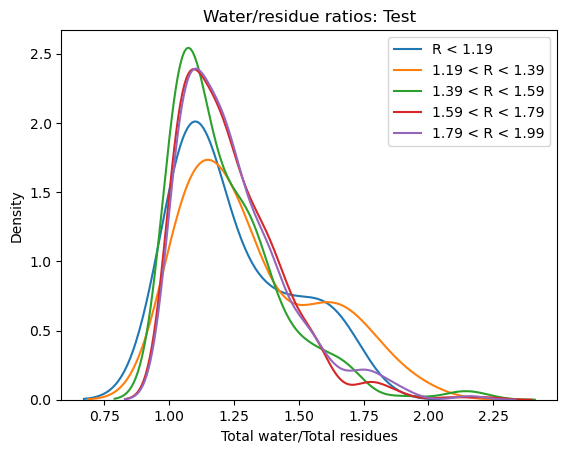

In [69]:
# Test set. water/residues for each PDB (summing).
# Loop through each resolution class.
fig, ax = plt.subplots()
x_label='Total water/Total residues'
for i,resolution in enumerate(test_resolutions[:-1]):
    df=df_AA_water_resolution_test
    if i == 0:
        df = df[df['resolution'] < test_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        df_PDF = pd.DataFrame(data, columns=[x_label])
        sns.kdeplot(df_PDF, x=x_label, label=f'R < {round(test_resolutions[i+1], 2)}')
    else:
        df = df[df['resolution'] >= resolution]
        df = df[df['resolution'] < test_resolutions[i+1]]
        data = list(df['wat_over_AA'].values)
        df_PDF = pd.DataFrame(data, columns=[x_label])
        sns.kdeplot(df_PDF, x=x_label, label=f'{round(resolution, 2)} < R < {round(test_resolutions[i+1], 2)}')
ax.set_xlabel("Total water/Total residues")
# ax.set_xlim(0.8, 4)
# plt.ylabel("Number of proteins")
ax.set_title("Water/residue ratios: Test")
plt.legend()
plt.savefig("figures/2_b_Resolution_test_Sum_wat_over_res_PDF.png", dpi=200)
# plt.show()

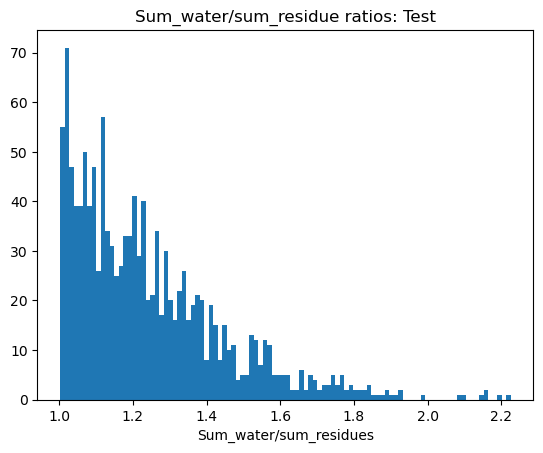

In [47]:
# Test set. water/residues for each PDB (summing).
data = list(S_w_over_r_test.values()) 
plt.hist(data, bins=100)
plt.xlabel("Sum_water/sum_residues")
# plt.ylabel("Number of proteins")
plt.title("Sum_water/sum_residue ratios: Test")
plt.savefig("figures/2_test_Sum_wat_over_res_dist.png", dpi=200)
plt.show()